In [21]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import util.util_validation as ut_val
from util.util_logging import load_confusion_matrix

pd.set_option('display.max_columns', None)
seaborn.set_style("darkgrid")

In [2]:
epoch = "last"

exclude_params_dict = {"tag": ["CropSize32", "divergent", "toSlow", "lrAdjust1", "lrAdjust2", "noCosine", "bszAdjust1"]}
keep_params_dict = {"aug": ["colorJitter", "grayscale"]}
# keep_params_dict = {"dataset": ["city_classification_original", "city_classification_diff", "city_classification_original+diff"]}
models_dict, df_modelNames = ut_val.collect_models_dict(epoch=epoch, dataset_classifier="", exclude_params_dict=exclude_params_dict, keep_params_dict=keep_params_dict)
print(df_modelNames.to_markdown(index=False))

| model_name                                                                            |
|:--------------------------------------------------------------------------------------|
| CE_animals10_diff_-1+4000_allAug                                                      |
| CE_animals10_diff_-1+8000_allAug                                                      |
| CE_animals10_diff_-1_allAug                                                           |
| CE_animals10_diff_4000_allAug                                                         |
| SupConHybrid_animals10_diff_-1+4000_cAug                                              |
| SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100            |
| SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100NoNormalize |
| SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug                                       |
| SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug_factor5cAugSameSAug                    |
| SupCon_5

## Table of Accuracies

In [3]:
acc_dict_val = {"model_name": []}
datasets_cm_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    acc_dict_val["model_name"].append(mn)

    cm_path_val = glob.glob(os.path.join(path_folder, f"val_{epoch}", "*", "cm", f"cm_val_epoch_{epoch}.csv"))
    datasets_cm_all = datasets_cm_all.union([cm_path.split('/')[-3] for cm_path in cm_path_val])
datasets_cm_all = sorted(datasets_cm_all)
for dset in datasets_cm_all:
    acc_dict_val[dset] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_cm_all:
        cm_dset_path_val = glob.glob(os.path.join(path_folder, f"val_{epoch}", dset, "cm", f"cm_val_epoch_{epoch}.csv"))
        if len(cm_dset_path_val) == 1:
            C_val = load_confusion_matrix(cm_dset_path_val[0])
            acc_val, acc_b_val = ut_val.compute_accuracies_form_cm(C_val)
            acc_dict_val[dset].append(f"{acc_val*100:.2f} ({acc_b_val*100:.2f})")
        else:
            acc_dict_val[dset].append("")

df_acc = pd.DataFrame.from_dict(acc_dict_val)

In [4]:
datasets_cm_select = sorted(set(datasets_cm_all).intersection(["animals10_diff_-1", "animals10_diff_4000", "animals10_diff_8000", "stylized_animals10"]))
df_acc.loc[(df_acc[datasets_cm_select].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), ["model_name"]+datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

,model_name,animals10_diff_-1,animals10_diff_4000,animals10_diff_8000,stylized_animals10
0,CE_animals10_diff_-1+4000_allAug,94.75 (94.04),93.01 (92.18),90.85 (89.70),39.21 (36.90)
1,CE_animals10_diff_-1+8000_allAug,94.08 (93.37),92.27 (91.16),90.60 (89.47),40.72 (38.38)
2,CE_animals10_diff_-1_allAug,94.92 (94.32),61.94 (60.00),51.28 (49.32),39.95 (34.69)
3,CE_animals10_diff_4000_allAug,69.56 (65.98),92.02 (91.08),88.69 (87.40),29.39 (27.73)
4,SupConHybrid_animals10_diff_-1+4000_cAug,57.98 (51.17),57.81 (51.03),,19.88 (17.00)
5,SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100,93.05 (92.50),92.21 (91.82),,38.71 (38.94)
6,SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100NoNormalize,53.48 (48.69),53.30 (48.66),,20.26 (17.72)
7,SupCon_20.0_animals10_diff_-1+4000_cAugSameSAug,93.37 (92.74),91.92 (91.11),,37.30 (37.19)
8,SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug_factor5cAugSameSAug,94.77 (94.11),93.41 (92.95),91.12 (90.36),39.88 (38.56)
9,SupCon_5.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor5,94.40 (93.61),93.24 (92.46),,40.15 (38.90)


In [5]:
datasets_cm_select = sorted(set(datasets_cm_all).intersection(["city_classification_original", "city_classification_diff"]))
df_acc.loc[(df_acc[datasets_cm_select].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), ["model_name"]+datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

,model_name,city_classification_diff,city_classification_original
13,SupCon_city_classification_original+diff_cAugSameSAug,82.34 (72.87),90.73 (85.39)
14,SupCon_city_classification_original_allAug,58.51 (49.58),91.58 (86.56)


## Table of Cue Conflict Shape Bias Metric

In [17]:
bias_dict = {"model_name": []}
datasets_bias_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    bias_dict["model_name"].append(mn)

    cue_conf_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", "*", "shape_bias.csv"))
    datasets_bias_all = datasets_bias_all.union([cue_conf_path.split('/')[-2] for cue_conf_path in cue_conf_paths])
datasets_bias_all = sorted(datasets_bias_all)
dset_cue_conf_plot_info_dict = dict()
for dset in datasets_bias_all:
    bias_dict[f"{dset}_sb"] = []
    bias_dict[f"{dset}_acc"] = []
    bias_dict[f"{dset}_acc_s"] = []
    bias_dict[f"{dset}_acc_t"] = []

    dset_cue_conf_plot_info_dict[dset] = [[], dict()]

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_bias_all:
        cue_conf_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", dset, "shape_bias.csv"))
        class_cue_conf_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", dset, "classes_shape_bias.csv"))

        if len(cue_conf_dset_paths) == 1:
            df_bias = pd.read_csv(cue_conf_dset_paths[0], index_col=0)
            shape_bias, acc, acc_shape, acc_texture = df_bias.loc[["shape_bias", "acc", "acc_shape", "acc_texture"]].values[:,0]
            bias_dict[f"{dset}_sb"].append(shape_bias)
            bias_dict[f"{dset}_acc"].append(acc)
            bias_dict[f"{dset}_acc_s"].append(acc_shape)
            bias_dict[f"{dset}_acc_t"].append(acc_texture)

            if len(class_cue_conf_dset_paths) == 1:
                df_bias.columns = [mn]
                df_class_bias = pd.read_csv(class_cue_conf_dset_paths[0], index_col=0)
                dset_cue_conf_plot_info_dict[dset][0].append(df_bias)
                dset_cue_conf_plot_info_dict[dset][1][mn] = df_class_bias
        else:
            bias_dict[f"{dset}_sb"].append("")
            bias_dict[f"{dset}_acc"].append("")
            bias_dict[f"{dset}_acc_s"].append("")
            bias_dict[f"{dset}_acc_t"].append("")

df_bias = pd.DataFrame.from_dict(bias_dict)
multiIndex_tuples = [("", "model_name")]
for dset in datasets_bias_all:
    multiIndex_tuples.extend([(dset, "shape_bias"), (dset, "acc"), (dset, "acc_shape"), (dset, "acc_texture")])

    dset_cue_conf_plot_info_dict[dset][0] = pd.concat(dset_cue_conf_plot_info_dict[dset][0], axis=1)
df_bias.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

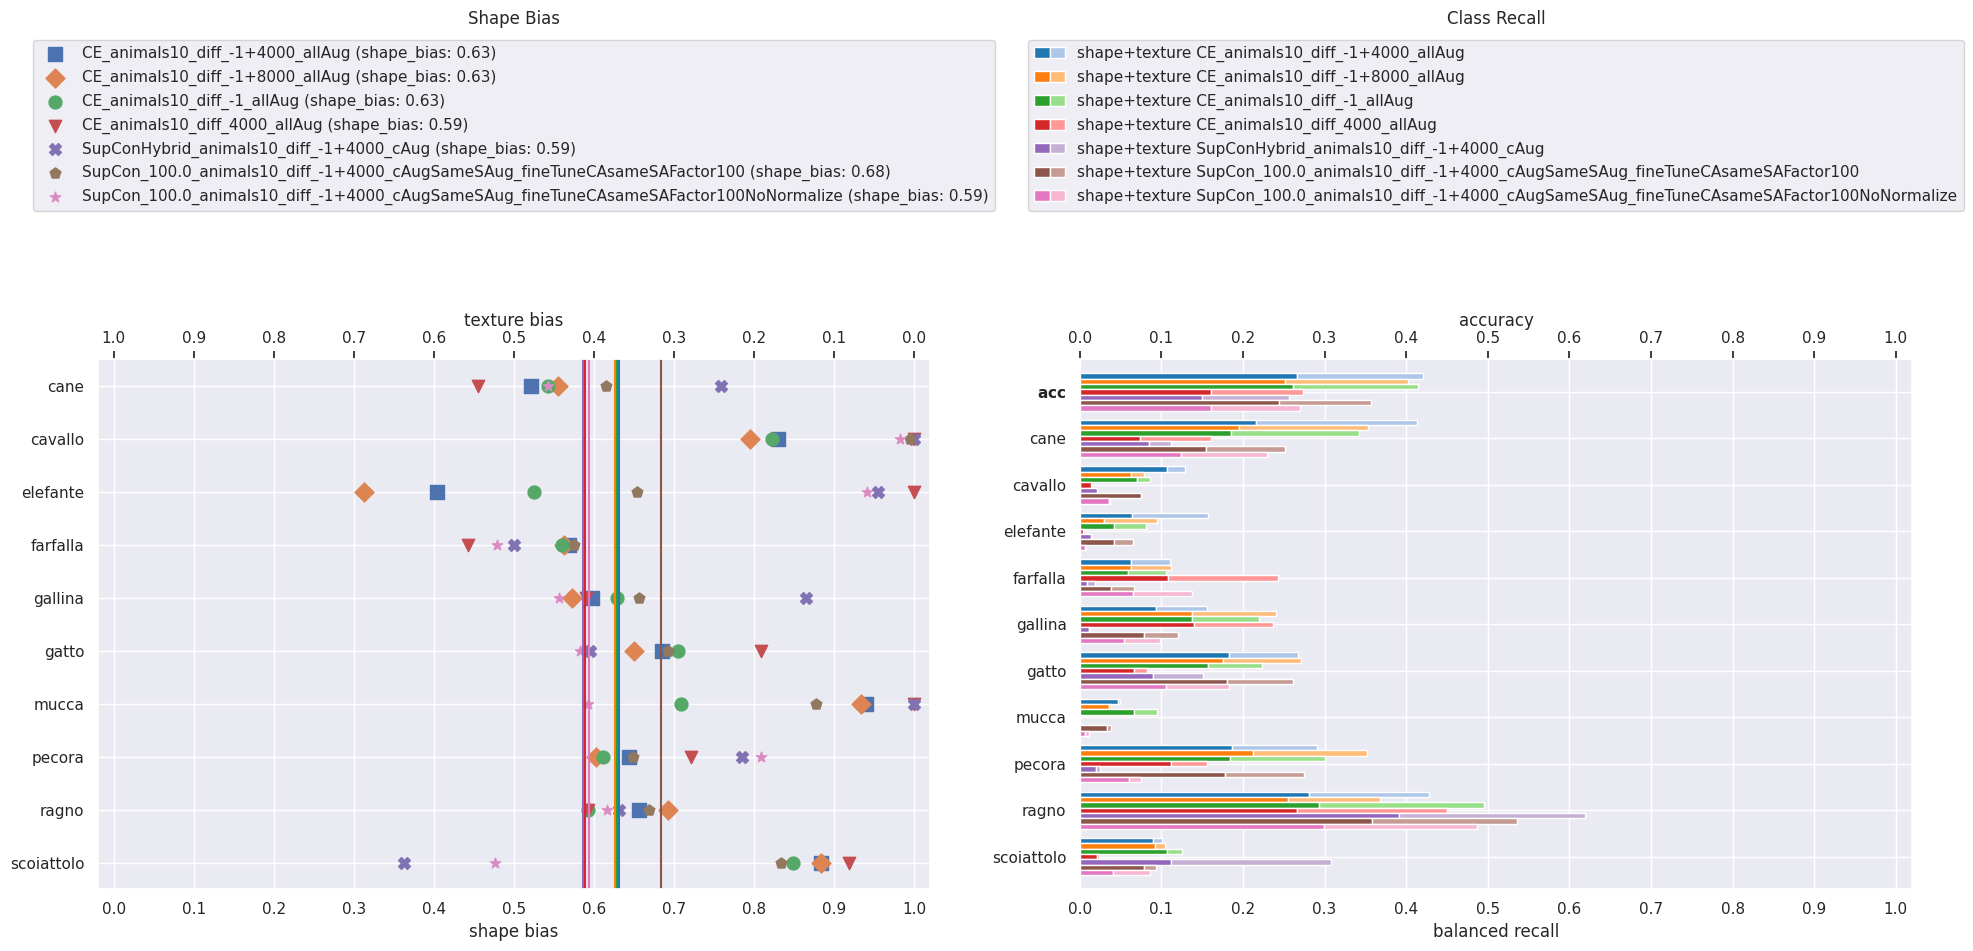

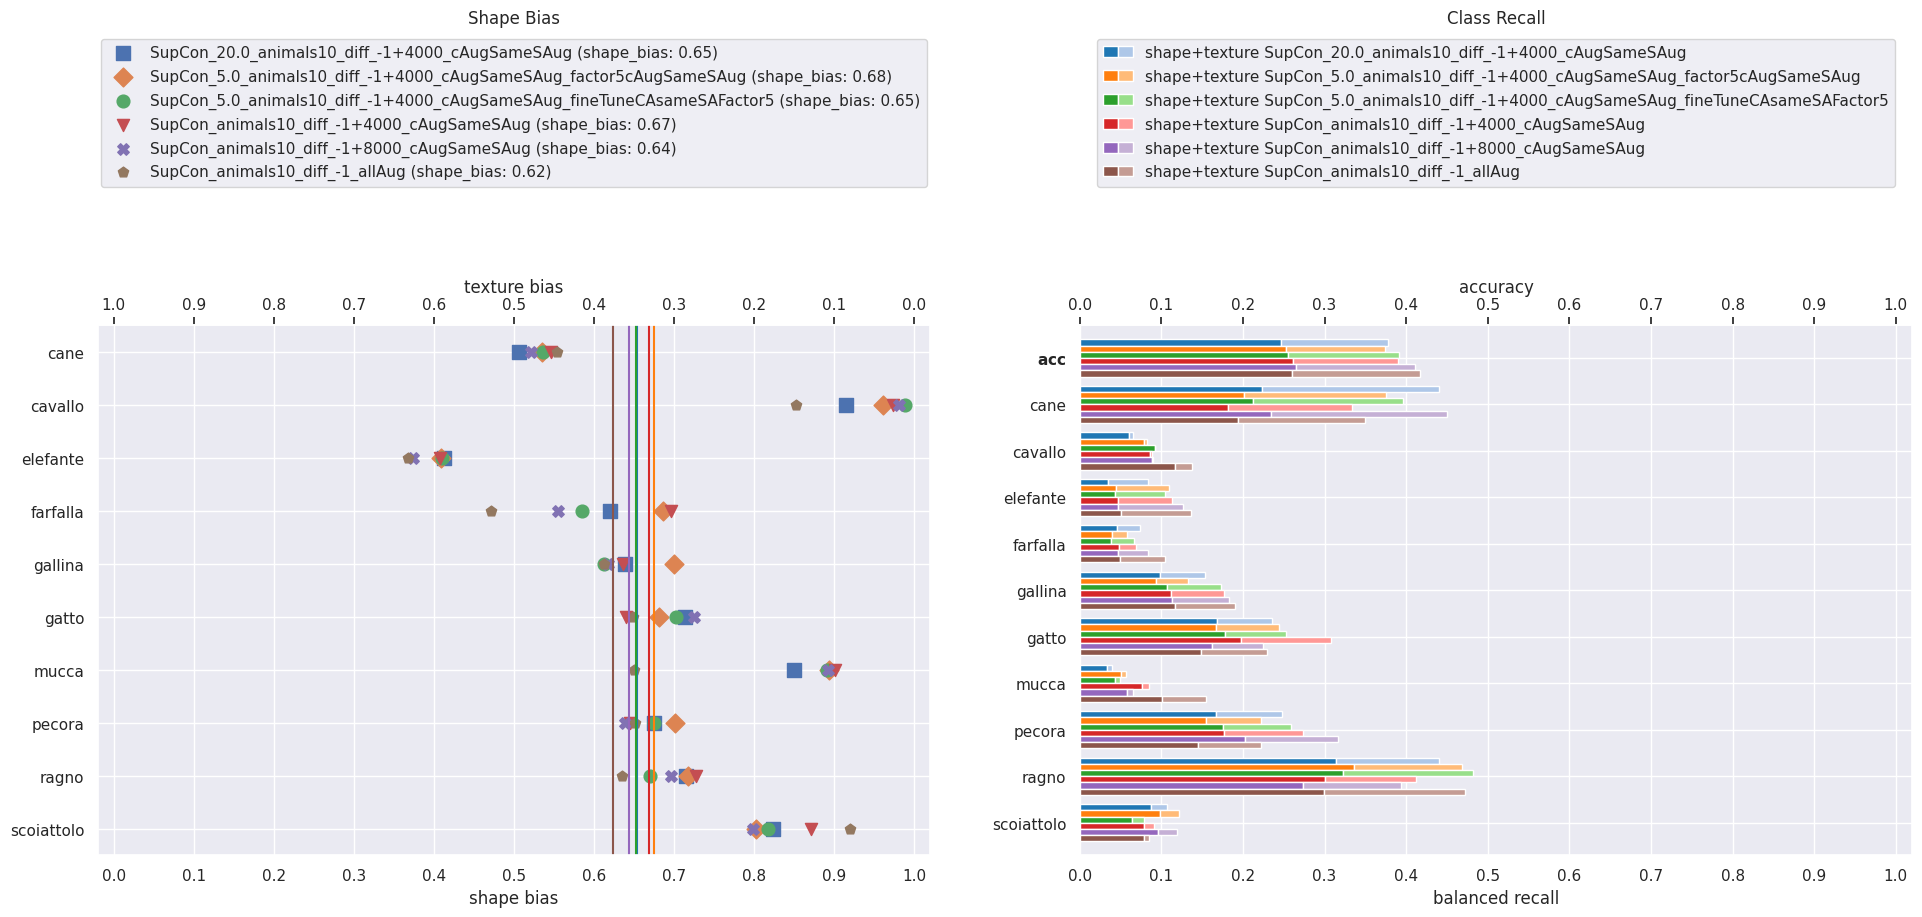

In [83]:
datasets_bias_selected = sorted(set(datasets_bias_all).intersection(["shape_texture_conflict_animals10_many"]))

for dset in datasets_bias_selected:
    df_biases, class_biasses = dset_cue_conf_plot_info_dict[dset]
    num_models = len(df_biases.columns)

    if num_models <= 10:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        fig.tight_layout(w_pad=3)

        ut_val.plot_shape_texture_conflict_bias(class_biasses, df_biases, ax=axs[0])
        ut_val.plot_class_recall_stacked(class_biasses, df_biases, ax=axs[1])
    else:
        num_splits = (num_models-1) // 10 + 1
        size_splits = [num_models // num_splits + (1 if i < num_models % num_splits else 0)  for i in range(num_splits)]
        model_names = list(df_biases.columns)
        for i in range(num_splits):
            start = sum(size_splits[:i])
            stop = sum(size_splits[:i+1])
            class_biasses_split = dict()
            for mn in model_names[start:stop]:
                class_biasses_split[mn] = class_biasses[mn]

            fig, axs = plt.subplots(ncols=2, figsize=(19, 6))
            fig.tight_layout(w_pad=6)

            ut_val.plot_shape_texture_conflict_bias(class_biasses_split, df_biases[model_names[start:stop]], ax=axs[0])
            ut_val.plot_class_recall_stacked(class_biasses_split, df_biases[model_names[start:stop]], ax=axs[1])


df_bias.loc[(df_bias[datasets_bias_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_bias_selected].style.background_gradient(
    subset=datasets_bias_selected, axis=None, gmap=df_bias[datasets_bias_selected].map(lambda x: np.nan if x == '' else x))

## Table of Correlation Coefficient Shape Bias Metric

In [64]:
dims_dict = {"model_name": []}
datasets_corr_coef_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    dims_dict["model_name"].append(mn)

    corr_coef_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CorrelationCoefficient", "*", "pred_dims.csv"))
    datasets_corr_coef_all = datasets_corr_coef_all.union([corr_coef_path.split('/')[-2] for corr_coef_path in corr_coef_paths])
datasets_corr_coef_all = sorted(datasets_corr_coef_all)
for dset in datasets_corr_coef_all:
    dims_dict[f"{dset}_shape"] = []
    dims_dict[f"{dset}_texture"] = []
    dims_dict[f"{dset}_color"] = []
    dims_dict[f"{dset}_remaining"] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_corr_coef_all:
        corr_coef_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CorrelationCoefficient", dset, "pred_dims.csv"))

        if len(corr_coef_dset_paths) == 1:
            df_dims = pd.read_csv(corr_coef_dset_paths[0], index_col=0)
            embedding_size = df_dims.values.sum()

            shape_dims, texture_dims, remaining_dims = df_dims[["shape_dims", "texture_dims", "remaining_dims"]].iloc[0]
            dims_dict[f"{dset}_shape"].append(f"{shape_dims} ({shape_dims/embedding_size:.4f})")
            dims_dict[f"{dset}_texture"].append(f"{texture_dims} ({texture_dims/embedding_size:.4f})")
            dims_dict[f"{dset}_remaining"].append(f"{remaining_dims} ({remaining_dims/embedding_size:.4f})")
            if "color_dims" in df_dims.columns:
                color_dims = df_dims["color_dims"].iloc[0]
                dims_dict[f"{dset}_color"].append(f"{color_dims} ({color_dims/embedding_size:.4f})")
            else:
                dims_dict[f"{dset}_color"].append("")
        else:
            dims_dict[f"{dset}_shape"].append("")
            dims_dict[f"{dset}_texture"].append("")
            dims_dict[f"{dset}_color"].append("")
            dims_dict[f"{dset}_remaining"].append("")

df_dims = pd.DataFrame.from_dict(dims_dict)
multiIndex_tuples = [("", "model_name")]
for dset in datasets_corr_coef_all:
    multiIndex_tuples.extend([(dset, "shape_dims"), (dset, "texture_dims"), (dset, "color_dims"), (dset, "remaining_dims")])
df_dims.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

In [63]:
datasets_corr_coef_selected = sorted(set(datasets_corr_coef_all).intersection(["shape_texture_conflict_animals10_many",
                                                                               "stylized_animals10Shape_animals10_diff_-1PatchSize30CJitterTexture_animals10_diff_-1PixelShuffledColor",
                                                                               "stylized_animals10Shape_animals10_diff_-1PatchSize30Texture"]))
df_dims.loc[(df_dims[datasets_corr_coef_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [62]:
datasets_corr_coef_selected = sorted(set(datasets_corr_coef_all).intersection(["animals10_diff_4000CJitterShape_animals10_diff_-1PatchSize30CJitterTexture_animals10_diff_-1PixelShuffledColor",
                                                                               "animals10_diff_4000CJitterShape_animals10_diff_-1PatchSize30Texture"]))
df_dims.loc[(df_dims[datasets_corr_coef_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [66]:
datasets_corr_coef_selected = sorted(set(datasets_corr_coef_all).intersection(["stylized_city_classificationShape_city_classification_originalPatchSize30CJitterTexture_city_classification_originalPixelShuffledColor",
                                                                               "stylized_city_classificationShape_city_classification_originalPatchSize30Texture"]))
df_dims.loc[(df_dims[datasets_corr_coef_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [65]:
datasets_corr_coef_selected = sorted(set(datasets_corr_coef_all).intersection(["city_classification_diffCJitterShape_city_classification_originalPatchSize30CJitterTexture_city_classification_originalPixelShuffledColor",
                                                                               "city_classification_diffCJitterShape_city_classification_originalPatchSize30Texture"]))
df_dims.loc[(df_dims[datasets_corr_coef_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

## Table of Distances

In [72]:
dist_dict = {"model_name": []}
datasets_1_dist = set()
datasets_2_dist = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    dist_dict["model_name"].append(mn)

    dist_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "*", "embeddings", "*_dist_to_*.csv"))
    datasets_1_dist = datasets_1_dist.union([dist_path.split('/')[-3] for dist_path in dist_paths])
    datasets_2_dist = datasets_2_dist.union([dist_path.split("_dist_to_")[-1].replace(".csv", '') for dist_path in dist_paths])
datasets_1_dist = sorted(datasets_1_dist)
datasets_2_dist = sorted(datasets_2_dist)
for dset1 in datasets_1_dist:
    for dset2 in datasets_2_dist:
        dist_dict[f"{dset1}_to_{dset2}_related"] = []
        dist_dict[f"{dset1}_to_{dset2}_class"] = []
        dist_dict[f"{dset1}_to_{dset2}_all"] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset1 in datasets_1_dist:
        for dset2 in datasets_2_dist:
            dist_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", dset1, "embeddings", f"{dset1}_dist_to_{dset2}.csv"))

            if len(dist_dset_paths) == 1:
                df_dist = pd.read_csv(dist_dset_paths[0], index_col=0)
                mean_rel, mean_class, mean_all = df_dist.T.loc[:,["mean_distance_related", "mean_distance_classes", "mean_distance_all_vs_all"]].iloc[0]

                dist_dict[f"{dset1}_to_{dset2}_related"].append(f"{mean_rel:.4f} ({mean_rel/mean_all:.4f})")
                dist_dict[f"{dset1}_to_{dset2}_class"].append(f"{mean_class:.4f} ({mean_class/mean_all:.4f})")
                dist_dict[f"{dset1}_to_{dset2}_all"].append(f"{mean_all:.4f} ({mean_all/mean_all})")
            else:
                dist_dict[f"{dset1}_to_{dset2}_related"].append("")
                dist_dict[f"{dset1}_to_{dset2}_class"].append("")
                dist_dict[f"{dset1}_to_{dset2}_all"].append("")

df_dist = pd.DataFrame.from_dict(dist_dict)
multiIndex_tuples = [("", "model_name")]
datasets_dist_all = []
for dset1 in datasets_1_dist:
    for dset2 in datasets_2_dist:
        dsets = f"{dset1}_to_{dset2}"
        multiIndex_tuples.extend([(dsets, "related"), (dsets, "in class"), (dsets, "all vs. all")])
        datasets_dist_all.append(dsets)
df_dist.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

In [74]:
datasets_dist_selected = sorted(set(datasets_dist_all).intersection(["animals10_diff_-1_to_animals10_diff_4000",
                                                                     "animals10_diff_-1_to_animals10_diff_8000",
                                                                     "animals10_diff_-1_to_stylized_animals10"]))
df_dist.loc[(df_dist[datasets_dist_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1),[""]+datasets_dist_selected].style

In [73]:
datasets_dist_selected = sorted(set(datasets_dist_all).intersection(["city_classification_original_to_city_classification_diff"]))
df_dist.loc[(df_dist[datasets_dist_selected].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1),[""]+datasets_dist_selected].style